> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

![](https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C4-white-bg.png)

# Lab: Implement the Attention Equation


<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_4/gdm_lab_4_2_implement_attention_equation.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Compute the attention weight vector for all layers of a transformer model.

15 minutes

## Overview

In this lab, you will implement the attention equation yourself. You will use the learned projection matrices $W_Q$, $W_K$, $W_V$ from the Gemma-1B model and use these three matrices to compute the attention weights and the new contextual embedding.




### What you will learn

By the end of this lab, you will:

* Understand how the attention weights are computed from query, key, and value matrices.

### Tasks

In this lab, you will:

* Load the pre-trained **Gemma-1B** model and use this model to compute query, key, and value matrices.
* Implement the attention equation.
* Visualize and compare your attention weights with those of the reference implementation.

If you are able to, we recommend running the code in this lab on **a Colab instance with a GPU**. See the section "How to use Google Colaboratory (Colab)" below for instructions on how to do this.


## How to use Google Colaboratory (Colab)


Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in **cells** that are executed on a remote server.

To run a cell, hover over the cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the *order in which you run the cells matters*. When you are working through a lab, make sure to always run *all* cells in order, otherwise the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

### Using Colab with a GPU

A **GPU** is a special type of hardware that can significantly speed up some types of computations of machine learning models. Several of the activities in this lab will also run a lot faster if you run them on a GPU.

Follow these steps to run the activities in this lab on a GPU:

1.  In the top menu bar, click on **Runtime**.
2.  Select **Change runtime type** from the dropdown menu.
3.  In the pop-up window under **Hardware Accelerator**, select **GPU** (usually listed as `T4 GPU`).
5.  Click **Save**.

Your Colab session will now restart with GPU access.

Note that access to GPUs is limited and at times, you may not be able to run this lab on a GPU. All activities will still work but they will run slower and you will have to wait longer for some of the cells to finish running.


## Imports

In this lab, you will mainly work with the JAX package to modify vectors and matrices. You will also use functions from the custom `ai_foundations` package to load Gemma and extract its parameters and to generate visualizations.

Run the following cell to import the required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install orbax-checkpoint==0.11.21
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

import jax # For working with vectors and matrices.
import jax.numpy as jnp # For working with vectors and matrices.
from ai_foundations import generation # For prompting the Gemma model.
from ai_foundations import visualizations # For visualizing attention weights.
from ai_foundations import attention # For working with Q,K,V matrices.
# For providing feedback on your implementation.
from ai_foundations.feedback.course_4 import attention as attention_feedback

## Load the model and visualize attention weights

As mentioned, you will use the parameters from the Gemma-1B model to compute the attention weights.

Run the following cell to load the Gemma-1B parameters. This also initializes a cache that speeds up the visualizations if you only adjust the layer parameter.


In [2]:
# Initialize caches for prompts.
previous_prompt = None
previous_prompt2 = None

# Load special version of the Gemma-1B model that provides access to attention
# weights and QKV matrices.
print("Loading Gemma-1B...")
model = generation.load_gemma("Gemma-1B-AttentionWeight")
print("Loaded Gemma-1B.")

Loading Gemma-1B...
Loaded Gemma-1B.


The following cell allows you to visualize the Gemma attention weights, as in the previous lab. You can use this cell as a reference and compare your own implementation to the output of the reference implementation to make sure that you have implemented everything accurately.

This visualization also includes an additional `show_all_weights` option. If you select this option, then the visualization will include attention weights for all target tokens, not just for the final token.

Make sure to run this cell for at least one prompt as it also extracts the query, key, and value matrices that you will use in later exercises.

Generated text: Jide was hungry so she went looking for food.


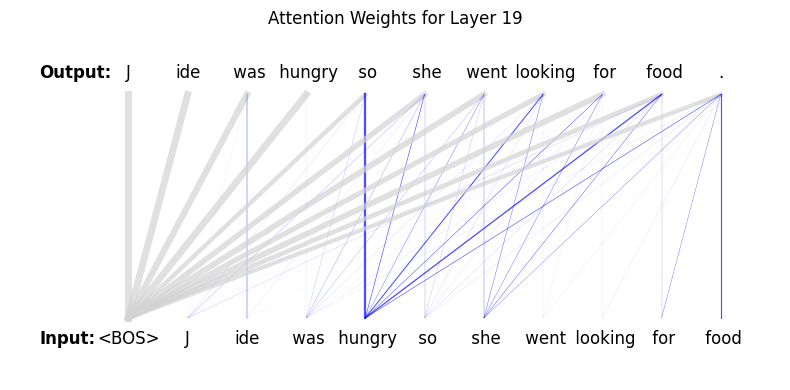

In [3]:
# @title Visualize attention weights (reference implementation)
layer = 19  # @param {type:"slider", min: 0, max: 25}

prompt = "Jide was hungry so she went looking for food"  # @param {type: "string"}
# @markdown Check the following box to display the attention weights for all tokens, not just for the generated one:
show_all_weights = True  # @param {type:"boolean"}


if prompt != previous_prompt:
  (
      output_text,
      _,
      tokenizer,
      attention_weights,
      _,
      qkv_dict,
  ) = generation.prompt_attention_transformer_model(
      prompt, model, sampling_mode="greedy"
  )
  tokens = [tokenizer.tokens[t] for t in tokenizer.encode(output_text)]
  previous_prompt = prompt

print(f"Generated text: {output_text}")

visualizations.visualize_attention(
    tokens,
    attention_weights[f"layer_{layer}"],
    layer,
    min_line_thickness=0,
    max_line_thickness=5,
    show_all_weights=show_all_weights,
)

## Coding Activity 1: Attention equation

------
> **💻 Your task:**
>
>Implement the attention mechanism for a specific layer in the following cell. To simplify things, the cell already makes a call to `get_qkv_matrices` which contains the query, key, and value projections for every token in the sentence.
>
>1. Inspect the query, key, and value projection matrices. What is their dimension?
>
>2. Compute $d_k$, the dimension of the key vectors which you need to compute the normalization factor. You can use [`.shape`](https://docs.jax.dev/en/latest/_autosummary/jax.Array.shape.html) for this.
>
> 3. Compute the logits by performing a matrix multiplication between the query projections and the key projections and normalizing them by the square root of $d_k$:
>
>    $$\mbox{logits} = \frac{QK^T}{\sqrt{d_k}}$$
>
>    Instead of `jnp.matmul`, you can also use the [`@` operator](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.matmul.html) to multiply two matrices. For example, `A @ B` computes the matrix product between matrices `A` and `B`. To compute the square root, use the function `jnp.sqrt`. Finally, remember that you can transpose a matrix `A` by calling [`A.T`](https://docs.jax.dev/en/latest/_autosummary/jax.Array.T.html).
>
> 4. Compute the attention weights `alpha` by applying the SoftMax function to the logits. You can either implement your own SoftMax function or use [`jax.nn.softmax`](https://docs.jax.dev/en/latest/_autosummary/jax.nn.softmax.html):
>
> $$\alpha = \mbox{SoftMax}(\mbox{logits})$$
>
>5. Compute the output of the attention mechanism by multiplying the attention weights $\alpha$ with the value projections:
>$$Y = \alpha V$$
>
>Once you have implemented the computations by filling in the missing parts of the next cell, run the test cell and the "Visualize attention weights (your implementation)" cell to see the attention weights.
------

In [4]:
def compute_attention(
    qkv_dict: dict[str, dict[str, jax.Array]], layer: int
) -> tuple[jax.Array, jax.Array, jax.Array]:
  """Computes the attention weights for a layer.

  Args:
    qkv_dict: A dictionary containing the raw query, key, and value
      projections for all layers. The keys are strings identifying the layers
      and matrix types, and values are the corresponding JAX arrays.
    layer: The specific layer for which to compute the attention weights.

  Returns:
    Y: The output of the attention layer. Shape: (n_tokens, embedding_dim).
    alpha: The attention weights. Shape: (n_tokens, n_tokens).
    logits: The raw logits used to compute the attention weights.
      Shape: (n_tokens, n_tokens).
  """
  # Extract the query, key, and value projection matrices from `qkv_dict`.
  query_proj, key_proj, value_proj = attention.get_qkv_matrices(qkv_dict, layer)
  d_k = query_proj.shape[-1]
  logits = (query_proj @ key_proj.T)/ jnp.sqrt(d_k)  # Compute the logits here.

  alpha = jax.nn.softmax(logits,axis=-1)  # Compute the attention vector here.

  Y = alpha @ value_proj  # Compute the output here.

  return Y, alpha, logits

In [5]:
# @title Run this cell to test your implementation
attention_feedback.test_compute_attention(compute_attention, qkv_dict)

✅ All tests passed. Your implementation is looking good.


### Visualize your attention weights

The following cell uses your implementation of the attention weights and visualizes the output of the `compute_attention` function. Enter the same prompt as you entered before and compare the visualization of your attention weights to the original ones that were extracted from Gemma.

For the same layer and the same prompt, both visualizations should be identical. If they are not, make sure to check your original implementation and try again.


Generated text: Jide was hungry so she went looking for food


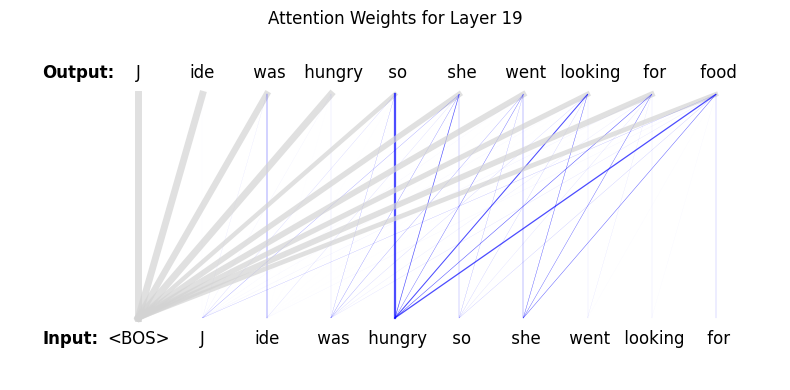

In [6]:
# @title Visualize attention weights (your implementation)
layer = 19  # @param {type:"slider", min: 0, max: 25}

prompt = "Jide was hungry so she went looking for"  # @param {type: 'string'}
# @markdown Check the following box to display the attention weights for all tokens, not just for the generated one:
show_all_weights = True  # @param {type:"boolean", label: "sfdsf"}

model_name = "Gemma-1B"

if prompt != previous_prompt2:
  (
      output_text2,
      _,
      tokenizer,
      attention_weights2,
      attention_mask2,
      qkv_dict2,
  ) = generation.prompt_attention_transformer_model(
      prompt, model, sampling_mode="greedy"
  )
  tokens2 = [tokenizer.tokens[t] for t in tokenizer.encode(output_text2)]
  previous_prompt2 = prompt

print(f"Generated text: {output_text2}")


attn_out, attn_weights, attn_logits = compute_attention(qkv_dict2, layer)
# Post-process attention weights to apply masking (to be covered in subsequent
# activities), so that the attention weights are idential to the ones computed
# by Gemma.
attn_weights_post_processed = attention.post_process_attention(
    attn_logits, attention_mask2
)

visualizations.visualize_attention(
    tokens2,
    attn_weights_post_processed,
    layer,
    min_line_thickness=0,
    max_line_thickness=5,
    show_all_weights=show_all_weights,
)


## Summary

In this lab, you implemented the computation of the attention mechanism of a transformer model. You used the key, query, and value projections from the Gemma model and combined them to compute the attention weights and the output of the attention mechanism.

## Solutions


The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.

It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.


If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.


To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.


### Coding Activity 1

In [8]:
# Complete implementation of compute_attention.
def compute_attention(
    qkv_dict: dict[str, dict[str, jax.Array]], layer: int
) -> tuple[jax.Array, jax.Array, jax.Array]:
  """Computes the attention weights for a layer.

  Args:
    qkv_dict: A dictionary containing the raw query, key, and value
      projections for all layers. The keys are strings identifying the layers
      and matrix types, and values are the corresponding JAX arrays.
    layer: The specific layer for which to compute the attention weights.

  Returns:
    Y: The output of the attention layer.
    alpha: The attention weights.
    logits: The raw logits used to compute the attention weights.
  """
  # Extract the query, key, and value projection matrices from `qkv_dict`.
  query_proj, key_proj, value_proj = attention.get_qkv_matrices(qkv_dict, layer)

  # Extract d_k.
  _, dim_key = key_proj.shape

  # Compute the logits = QK.T/sqrt(d_k)
  logits = (query_proj @ key_proj.T) / jnp.sqrt(dim_key)

  # Compute the attention weights 𝛼.
  alpha = jax.nn.softmax(logits)

  # Compute the output Y = 𝛼V.
  Y = alpha @ value_proj

  return Y, alpha, logits
